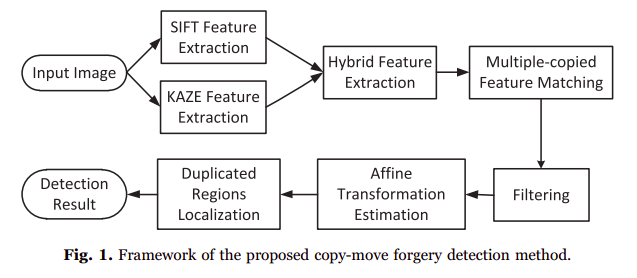

https://sci-hub.ren/https://doi.org/10.1016/j.engappai.2016.12.022

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import correlate2d

In [4]:
class HybridDetector:
    def __init__(self, image1):
        self.SIFT = cv2.xfeatures2d.SIFT_create()
        self.KAZE = cv2.KAZE_create()
        if image1 is None:
            raise Exception("Image not found")
        self.img = image1
    
    def get_kaze(self, image):
        kp, desc = self.KAZE.detectAndCompute(image,None)
        return kp, desc
    
    def get_sift(self, image):
        kp, desc = self.SIFT.detectAndCompute(image,None)
        return kp, desc
    
    def match(self, kp, d):
        # Takes keypoints and descriptors and returns p1 and p2, lists of corresponding matches
        bf_matcher = cv2.BFMatcher(cv2.NORM_L2)
        matches = bf_matcher.knnMatch(d,d,k=10)
        ratio = 0.5
        spatial_sep = 10
        mkp1 = []
        mkp2 = []
        for m in matches:
            j = 1
            while(m[j].distance < ratio * m[j+1].distance):
                j = j + 1

            for k in range(1, j):
                temp = m[k]

                # Check if the keypoints are spatial separated
                # if pdist( np.array([kp[temp.queryIdx].pt, kp[temp.trainIdx].pt]) ) > spatial_sep:
                if np.linalg.norm(np.array(kp[temp.queryIdx].pt)-np.array(kp[temp.trainIdx].pt))>spatial_sep:
                    if len(mkp1)>0:
                        if kp[temp.queryIdx].pt != mkp1[-1].pt or kp[temp.trainIdx].pt != mkp2[-1].pt:
                            mkp1.append(kp[temp.queryIdx])
                            mkp2.append(kp[temp.trainIdx])

                    else:
                        mkp1.append(kp[temp.queryIdx])
                        mkp2.append(kp[temp.trainIdx])

        p1 = np.int64([kp1.pt for kp1 in mkp1])
        p2 = np.int64([kp2.pt for kp2 in mkp2])
        
        return p1, p2
    
    def coeff(self, I,T):
        #3E-5 seconds per pixel, pretty slow
        if I.shape != T.shape:
            raise Exception("Image and Target have unequal shape")
        I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
        T = cv2.cvtColor(T, cv2.COLOR_BGR2GRAY)
        C = np.zeros(I.shape)
        I = np.pad(I,2,mode='edge')
        T = np.pad(T,2,mode='edge')
        cter = 0
        for x in range(2,I.shape[0]-2):
            for y in range(2,I.shape[1]-2):
                omegai = I[x-2:x+3,y-2:y+3]
                omegat = T[x-2:x+3,y-2:y+3]
                idash = np.mean(omegai)
                tdash = np.mean(omegat)
                imc = omegai# - idash               #remove mean centering
                tmc = omegat# - tdash
                top = np.matmul(imc, tmc)
                top_sum = np.sum(top)
                bottom = np.matmul(np.square(imc),np.square(tmc))
                bottom = np.sum(bottom)
                if bottom==0:
                    cter+=1
                bottom_root = np.sqrt(bottom)
                if bottom_root == 0:
                    C[x-2,y-2] = 0
                else:
                    C[x-2,y-2] = top_sum/bottom_root
        return C    

        
    
    def detect(self):
        # Do stuff here
        
        #Find keypoints
        kp_k, d_k = self.get_kaze(self.img)
        kp_s, d_s = self.get_sift(self.img)
        
        self.features_drawn = cv2.drawKeypoints(self.img, kp_k,np.array([]))
        self.features_drawn = cv2.drawKeypoints(self.features_drawn, kp_s,np.array([]))
        
        
        
        p1_k, p2_k = self.match(kp_k,d_k)
        p1_s, p2_s = self.match(kp_s,d_s)
        
        if (p1_k.shape != p2_k.shape):
            raise Exception("KAZE P1-P2 size mismatch")
        if p1_s.shape != p2_s.shape:
            raise Exception("SIFT P1-P2 size mismatch")
        p1 = np.concatenate((p1_k,p1_s))
        p2 = np.concatenate((p2_k,p2_s))

        
    
        #Filter keypoints
        
        ## SLIC
        # convert to LAB space, apply 3x3 gaussian filter
        seg_img = self.img
        seg_img = cv2.cvtColor(seg_img, cv2.COLOR_BGR2LAB)
        seg_img = cv2.GaussianBlur(seg_img,(3,3),0)
        reg_size = 60
        regulizer = 0.8
        # slic=100, slico=101, etc
        SLICer = cv2.ximgproc.createSuperpixelSLIC(seg_img, 100, reg_size, regulizer)
        SLICer.iterate()
        #segmentation map
        mask = SLICer.getLabels()
        self.segment_mask = mask.copy()
        boundaries = SLICer.getLabelContourMask(thick_line=True)
        self.num_segments = SLICer.getNumberOfSuperpixels()
        self.segmented = self.features_drawn.copy()
        for i in range(boundaries.shape[0]):
            for j in range(boundaries.shape[1]):
                if boundaries[i,j] == -1:
                    self.segmented = [0,0,0]
        
        
        # Count number of points in p1, p2 per patch
        patch_dict={} #key is patch number, value is number of points from p1, p2 in the patch
        to_remove=[]#len = len(p1), to_remove[i] denotes whether p1[i] and p2[i] are slated for removal
        #            based on being in not dense patches
        for i in range(len(p1)):
            if mask[tuple(p1[i].astype(int))[::-1]] in patch_dict:
                patch_dict[mask[tuple(p1[i].astype(int))[::-1]]].append(i)
            else:
                patch_dict[mask[tuple(p1[i].astype(int))[::-1]]] = []
                patch_dict[mask[tuple(p1[i].astype(int))[::-1]]].append(i)
            
            if mask[tuple(p2[i].astype(int))[::-1]] in patch_dict:
                patch_dict[mask[tuple(p2[i].astype(int))[::-1]]].append(i)
            else:
                patch_dict[mask[tuple(p2[i].astype(int))[::-1]]] = []
                patch_dict[mask[tuple(p2[i].astype(int))[::-1]]].append(i)
            to_remove.append(0)
            
        # If number of points in any patch is less than ETA, remove points
        p1d = []
        p2d = []
        eta = 2
        for key in patch_dict:
            if len(patch_dict[key]) <= eta:
                for i in patch_dict[key]:
                    to_remove[i]=1
        
        for i in range(len(p1)):
            if not to_remove[i]:
                p1d.append(p1[i])
                p2d.append(p2[i])

        p1 = np.array(p1d)
        p2 = np.array(p2d)
        
        #draw matches
        self.allmatches = self.features_drawn.copy()
        for i in range(p1.shape[0]):
            self.allmatches = cv2.line(self.allmatches,(p1[i][0],p1[i][1]),(p2[i][0],p2[i][1]),\
                                         (255,0,0),1)
        
        
        del p1d
        del p2d
        
        #USE RANSAC
        ransac_beta=3 #0.05 in the paper, but don't know if this the same as in the \
                      #opencv implementation (3)
        inlier_sets=[]
        count1 = 0
        matches_left = len(p1)
        while matches_left > 5:
            
            aff_t, inliers = cv2.estimateAffinePartial2D(p1,p2,method=cv2.RANSAC,\
                                                         ransacReprojThreshold=ransac_beta,maxIters=1000)
            p1i=[]
            p2i=[]
            for i in range(len(inliers)):
                if inliers[i] == 1:
                    p1i.append(p1[i])
                    p2i.append(p2[i])
                    matches_left -= 1

            p1_n=[]
            p2_n=[]


            for i in range(len(list(p1))):
                f=False
                for j in range(len(list(p1i))):
                    if np.array_equal(p1[i],p1i[j]) and np.array_equal(p2[i],p2i[j]):
                        f=True
                        break
                if not f:
                    p1_n.append(p1[i])
                    p2_n.append(p2[i])
            p1_n = np.array(p1_n)
            p2_n = np.array(p2_n)

            
            p1 = p1_n
            p2 = p2_n
            del p1_n
            del p2_n
            inlier_sets.append([aff_t,np.array(p1i),np.array(p2i)])
            count1+=1
        
        #draw inlier matches
        self.matchesdrawn = self.features_drawn.copy()
        for ind,i in enumerate(inlier_sets):
            for j in range(i[1].shape[0]):
                self.matchesdrawn = cv2.line(self.matchesdrawn,(i[1][j][0],i[1][j][1]),\
                                             (i[2][j][0],i[2][j][1]),((ind*100)%255,\
                                                                      (ind*100)%255,(ind*100)%255),1)
        
        
        print("number of transformations: ",len(inlier_sets))

        base = self.img.copy()
        for i in range(len(inlier_sets)):
            ft = inlier_sets[i][0]
            bt = cv2.invertAffineTransform(ft)
            fimg = cv2.warpAffine(base, ft, base.shape[1::-1])
            bimg = cv2.warpAffine(base, bt, base.shape[1::-1])
            fc = self.coeff(fimg,base)
            bc = self.coeff(bimg,base)
            #threshold using 0.55
            thresh = 140 #0.55*255
            _,fc_t = cv2.threshold(fc,thresh,255,cv2.THRESH_BINARY)
            _,bc_t = cv2.threshold(bc,thresh,255,cv2.THRESH_BINARY)
            inlier_sets[i].append(fc_t)
            inlier_sets[i].append(bc_t)

        return inlier_sets
            

In [5]:
img = cv2.imread('../pika2.png')
h = HybridDetector(img)
inlier_sets = h.detect()

(25, 2) (25, 2)
inlier sets:  2
(305, 503, 3) (305, 503, 3)
Shapes passed to coeff:  (305, 503, 3) (305, 503, 3)
C:  (305, 503)
58146 / 153415
Shapes passed to coeff:  (305, 503, 3) (305, 503, 3)
C:  (305, 503)
36210 / 153415
(305, 503, 3) (305, 503, 3)
Shapes passed to coeff:  (305, 503, 3) (305, 503, 3)
C:  (305, 503)
36231 / 153415
Shapes passed to coeff:  (305, 503, 3) (305, 503, 3)
C:  (305, 503)
58182 / 153415
